In [719]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind

In [662]:
adult_train = pd.read_csv("adult.data", sep=',\s+', engine='python')
adult_test = pd.read_csv("adult.test", sep=',\s+', engine='python')

In [663]:
adult_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [664]:
# drop incomplete instances, contain ? values
adult_test = adult_test[(adult_test != '?').all(1)]
adult_train = adult_train[(adult_train != '?').all(1)]

# drop fnlwgt column, which is uninformational and might cause overfitting
adult_test = adult_test.drop(columns=["fnlwgt"])
adult_train = adult_train.drop(columns=["fnlwgt"])

In [665]:
# separate labels
adult_test_y = adult_test['outcome']
adult_test_X = adult_test.loc[:, adult_test.columns != 'outcome']
adult_train_y = adult_train['outcome']
adult_train_X = adult_train.loc[:, adult_train.columns != 'outcome']

In [666]:
# transform labels to 0 and 1, above 50k is favorable outcome
adult_test_y = adult_test_y.map({'<=50K.': 0, '>50K.': 1})
adult_train_y = adult_train_y.map({'<=50K': 0, '>50K': 1})

# transform dataframes into numpy arrays
# adult_test_y = adult_test_y.to_numpy()
# adult_test_X = adult_test_X.to_numpy()
# adult_train_y = adult_train_y.to_numpy()
# adult_train_X = adult_train_X.to_numpy()

In [667]:
# remove race and sex from model data
adult_train_sex = adult_train_X["sex"]
adult_test_sex = adult_test_X["sex"]
adult_train_race = adult_train_X["race"]
adult_test_race = adult_test_X["race"]
adult_train_nc = adult_train_X["native-country"]
adult_test_nc = adult_test_X["native-country"]
adult_train_X = adult_train_X.drop(columns=["race", "sex", "native-country"])
adult_test_X = adult_test_X.drop(columns=["race", "sex", "native-country"])

In [668]:
# convert to one-hot encoding
adult_train_cat_X = pd.get_dummies(adult_train_X)
adult_test_cat_X = pd.get_dummies(adult_test_X)

# align NL origin column between train and testset
# temp = adult_train_cat_X["native-country_Holand-Netherlands"]
# adult_train_cat_X = adult_train_cat_X.loc[:, adult_train_cat_X.columns != 'native-country_Holand-Netherlands']
# adult_train_cat_X["native-country_Holand-Netherlands"] = temp
# adult_test_cat_X["native-country_Holand-Netherlands"] = 0

In [669]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)
# tree.fit(adult_train_cat_X, adult_train_y)

parameter_grid={"criterion":["entropy"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=2)
tree_cv.fit(adult_train_cat_X, adult_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 90 candidates, totalling 270 fits


DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       random_state=42)

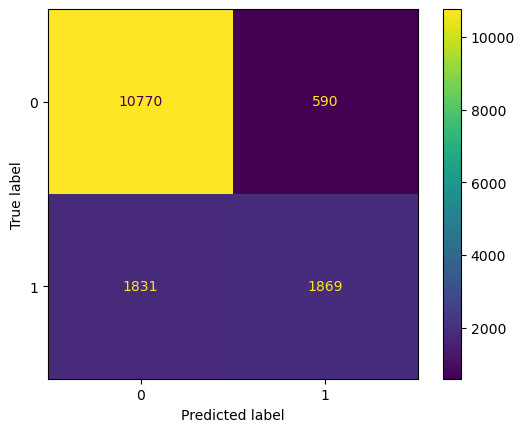

In [670]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(adult_test_cat_X)
cm = confusion_matrix(adult_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [671]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(adult_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(adult_test_y, y_pred)}")

Balanced accuracy on test set: 0.7265992577084126
ROC-AUC score on test set: 0.7265992577084127


In [672]:
column_names = [name for name in adult_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7073.50
|   |   |--- class: 0
|   |--- capital-gain >  7073.50
|   |   |--- class: 1
|--- marital-status_Married-civ-spouse >  0.50
|   |--- education-num <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education-num >  12.50
|   |   |--- class: 1



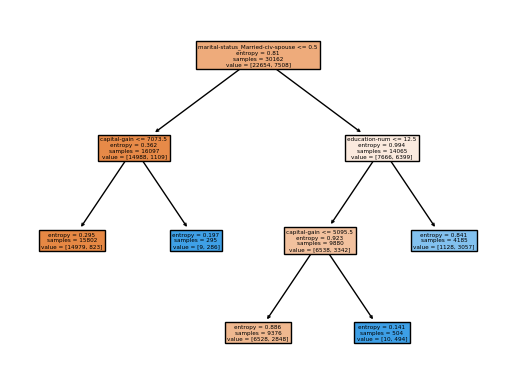

<Figure size 3840x2880 with 0 Axes>

In [673]:
plot_tree(best_tree, feature_names=adult_train_cat_X.columns, filled=True)
plt.figure(dpi=600)
plt.show()

In [674]:
n_nodes = best_tree.tree_.node_count
children_left = best_tree.tree_.children_left
children_right = best_tree.tree_.children_right
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

In [675]:
# taken from: https://stackoverflow.com/questions/56334210/how-to-extract-sklearn-decision-tree-rules-to-pandas-boolean-conditions

def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] !=-1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] !=-1):
        right = find_path(children_right[node_numb], path, x)
    if left or right :
        return True
    path.remove(node_numb)
    return False


def get_rule(df_name, path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += f"{df_name}['{column_names[feature[node]]}']<= {threshold[node]} \t "
            else:
                mask += f"{df_name}['{column_names[feature[node]]}']> {threshold[node]} \t "
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [677]:
# Leaves
leave_id = best_tree.apply(adult_test_cat_X)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule("adult_train_cat_X", paths[key], column_names)
    
rules

{4: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']> 12.5  ",
 5: "adult_train_cat_X['marital-status_Married-civ-spouse']<= 0.5 & adult_train_cat_X['capital-gain']<= 7073.5  ",
 6: "adult_train_cat_X['marital-status_Married-civ-spouse']<= 0.5 & adult_train_cat_X['capital-gain']> 7073.5  ",
 7: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']<= 12.5 & adult_train_cat_X['capital-gain']<= 5095.5  ",
 8: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']<= 12.5 & adult_train_cat_X['capital-gain']> 5095.5  "}

In [771]:
def positive_rules(rules):
    """From the extracted rules, return those that have a favorable classification"""
    
    # positive rules are those that end in > X
    return [rules[rule] for rule in rules if '>' in rules[rule].split('&')[-1]]


def oracle(df, sens_df, rule, s_i, mechanism=None, epsilon=0.05, delta=0):
    """Returns some (differentially privatised) statistics on the sensitive attribute for the specified dataframe and rule"""
    
    no_mechanism = sens_df[df[pd.eval(rule)].index].value_counts(sort=False)[s_i]
    
    if mechanism == "laplacian":
        # this is a histogram query so the l1-sensitivity = 1 as per Dwork & Roth 
        sensitivity = 1
        return no_mechanism + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
    elif mechanism == "gaussian":
        if delta <= 0 or delta > 1 or epsilon <= 0 or epsilon > 1:
            raise ValueError("The value of delta should be in (0,1] when using the gaussian mechanism")
            
        # this is a histogram query so the l2-sensitivity = 2 as per Dwork & Roth
        sensitivity = 2
        return no_mechanism + np.random.normal(loc=0, scale=2 * sensitivity**2 * np.log(1.25 / delta) / epsilon**2)
    
    elif mechanism == "exponential":
        # this query can only change by 1 if an instance is omitted so l1-sensitivity = 1
        sensitivity = 1
        
        # np.arange is [start, stop) so + 1 for entire possible range
        possible_values = np.arange(0, sum(sens_df[df[pd.eval(rule)].index].value_counts()) + 1)
        
        # the utility is higher when the value is closer to the actual value
        utility_scores = np.array([no_mechanism - abs(no_mechanism - value) for value in possible_values])
        probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
        
        # normalize probabilties to sum to 1
        probabilities = probabilities / np.linalg.norm(probabilities, ord=1)
        return np.random.choice(possible_values, p=probabilities)

    return no_mechanism

oracle(adult_train_cat_X, adult_train_sex, rules[4], "Male", "exponential", epsilon=0.05, delta=0.1)

3955

In [759]:
def statistical_parity(y_pred, df_sens):
    accept_rates = []
    
    for sens_attr in df_sens.unique():
        accept_rates.append(sum((df_sens == sens_attr) & y_pred) / sum(df_sens == sens_attr))
        
    return min(accept_rates) / max(accept_rates)


def estimate_sp(pos_ruleset, dataset, sens_dataset, S, mechanism, epsilon, delta):
    """Returns the Statistical Parity of a privacy mechanism for a tree"""
    counts_per_si = np.zeros(len(S))
    total_per_si = sens_dataset.value_counts(sort=False).to_numpy()
    total = 0
    
    # we can calculate the last count ourselves so we iterate one less
    for rule in pos_ruleset:
        rule_counts = np.zeros(len(S))
        rule_total = len(sens_dataset[pd.eval(rule)])
        
        # because the queries are disjoint, epsilon remains equal across queries
        for i, s_i in enumerate(S[:-1]):
            rule_counts[i] += round(oracle(dataset, sens_dataset, rule, s_i, mechanism, epsilon, delta))
            
        rule_counts[-1] += rule_total - np.sum(rule_counts[:-1])
        counts_per_si += rule_counts
    
    return np.min(counts_per_si / total_per_si) / np.max(counts_per_si / total_per_si)


def experiment(ruleset, rule_pred, dataset, sens_dataset, epsilon, 
               delta=0.0001, mechanisms=["exponential", "gaussian", "laplacian"], runs=50):
    """Compares average Statistical Parity Error for different mechanisms"""
    
    pos_rules = positive_rules(ruleset)
    actual_sp = statistical_parity(rule_pred, sens_dataset)
    errors = np.zeros((runs, len(mechanisms)))
    S = sens_dataset.value_counts(sort=False).index
    
    for row in range(runs):
        for col, mechanism in enumerate(mechanisms):
            errors[row, col] = abs(estimate_sp(pos_rules, dataset, sens_dataset, S, mechanism, epsilon, delta) - actual_sp)
            
    return errors


sp_errors = experiment(rules, best_tree.predict(adult_train_cat_X), adult_train_cat_X, adult_train_sex, epsilon=0.4)
avg_errs = np.mean(sp_errors, axis=0)
std_errs = np.std(sp_errors, ddof=1, axis=0)

/var/folders/d6/97vsb8ys2xsd5zzsdl4ndt6c0000gn/T/ipykernel_49552/752380357.py:35: RuntimeWarning: overflow encountered in exp
  probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/numpy/linalg/linalg.py:2538: RuntimeWarning: overflow encountered in reduce
  return add.reduce(abs(x), axis=axis, keepdims=keepdims)
/var/folders/d6/97vsb8ys2xsd5zzsdl4ndt6c0000gn/T/ipykernel_49552/752380357.py:38: RuntimeWarning: invalid value encountered in divide
  probabilities = probabilities / np.linalg.norm(probabilities, ord=1)


ValueError: probabilities contain NaN

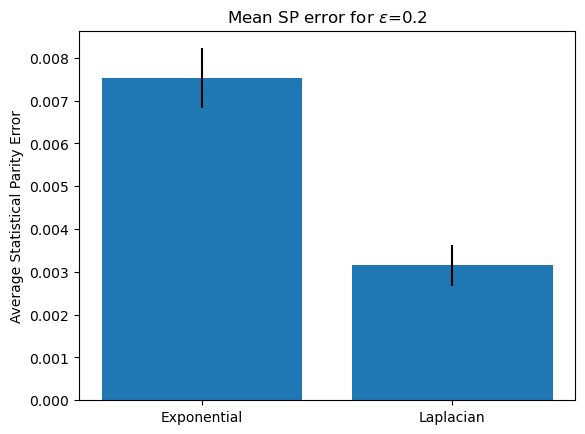

In [757]:
uncertainty = std_errs / np.sqrt(len(sp_errors[:,1]))

plt.bar([0,1], [avg_errs[0], avg_errs[2]], tick_label=["Exponential", "Laplacian"], yerr=[uncertainty[0], uncertainty[2]])
plt.title("Mean SP error for $\epsilon$=0.2")
plt.ylabel("Average Statistical Parity Error")
plt.show()

In [758]:
ttest_ind(sp_errors[:,0], sp_errors[:,2], alternative='greater')

Ttest_indResult(statistic=5.144735411440702, pvalue=6.88210862877214e-07)

In [767]:
np.exp(0.4 * 10002542 / (2 * 1))

/var/folders/d6/97vsb8ys2xsd5zzsdl4ndt6c0000gn/T/ipykernel_49552/925365052.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(0.4 * 10002542 / (2 * 1))


inf